Paramètres:
- N premiers à l'achat (on verra ensuite pour la vente)
- B/S/BS pour acheter les winners, vendre les loosers, acheter|vendre les deux
- Granularité (1m, 15m, 1h, 1D)
- Période de backtest (1D, 1W, 1M, 1Y, 5Y)
- Périodes des indicateurs

Idées de perfectionnements du model :
- %MRC
- Momentum : - Utiliser un DPO pour déterminer le momentum réel par rapport à l'Axe + bollinger bandes + essouflement (RSI centré)
- Ecarter les anomalies (percentiles/IQR ?)
- Clusteriser les stocks ?
- Utiliser un MCMC pour déterminer les espérances de gain fonction des écarts-types ?
- Ratio de Sharpe (Rendement/Volatilité)

Télécharger seulement à la fin des données, c'est accessoire. On peut partir sur 20 tickers pour commencer, la partie screening est à part.



In [1]:
pip install fix_yahoo_finance --upgrade --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import time

# Setup des paramètres
TIMEFRAME = 2000  # Nombre de lignes d'historique
INTERVAL = '1d'  # Intervalle de données
RAB = 50  # Période d'historique supplémentaire


# Télécharger les données des bons du Trésor (Taux sans risque)
rf_ticker = "^IRX"
rf_data = yf.download(rf_ticker, period="max", interval="1d")
rf_data['Return'] = rf_data['Close'] / 100
rf_data.index = pd.to_datetime(rf_data.index)
sp500 = yf.download('^GSPC', period="max", interval="1d")
sp500.index = pd.to_datetime(sp500.index)

# Liste des tickers du CAC40 (ou autre indice)
tickers = [
    # CAC40 tickers
    "AIR.PA", "AI.PA", "BNP.PA", "CAP.PA", "CA.PA", "ACA.PA", "BN.PA", "DSY.PA",
    "ENGI.PA", "EL.PA", "KER.PA", "LVMH.PA", "ML.PA", "OR.PA", "RI.PA", "SAF.PA",
    "SAN.PA", "SGO.PA", "STM.PA", "SU.PA", "TEP.PA", "TTE.PA", "VIE.PA", "DG.PA",
    "WLN.PA", "P.PA", "HO.PA", "EN.PA", "PUB.PA", "RMS.PA",
    # S&P 500 tickers
    "MSFT", "GOOGL", "AMZN", "FB", "BRK.B", "TSLA", "NVDA", "V", "JPM",
    "JNJ", "WMT", "PG", "MA", "DIS", "HD", "PYPL", "INTC", "CSCO", "VZ", "UNH",
    "ADBE", "NFLX", "KO", "PFE", "XOM", "MRK", "NKE", "ABT", "PEP", "CRM",
    "TMO", "MDT", "LLY", "MS", "AVGO", "BA", "COST",
    # NASDAQ tickers
    "TXN", "QCOM", "MU", "INTU", "AMD", "AMAT", "EBAY", "GILD", "SBUX", "BIDU", 
   "EXPE",
    # DAX tickers
    "ADS.DE", "ALV.DE", "BAS.DE", "BMW.DE", "CON.DE", "DB1.DE", "DTE.DE", "LHA.DE",
    "LIN.DE", "MUV2.DE", "RWE.DE", "SAP.DE", "SIE.DE", "VOW3.DE", "ZAL.DE",
    # FTSE tickers
    "AAL.L", "ABF.L", "ADM.L", "AHT.L", "AV.L", "BA.L", "BARC.L", "BATS.L", "BP.L",
    "BTI.L", "CNA.L", "DGE.L", "GSK.L", "HSBC.L", "IMB.L", "ITV.L", "LGEN.L", "LLOY.L",
    "RDSA.L"
    # EURO STOXX 50 tickers
    "ADS.DE", "BAS.DE", "BNP.PA", "DAI.DE", "FRE.PA", "LVMH.PA", "MC.PA", "OR.PA", 
    "RWE.DE", "SAP.DE", "SIE.DE", "VOW3.DE", "AIR.PA", "UCG.MI", "TOTF.PA", "INGA.AS", 
    "GSK.L", "BMW.DE", "AXA.PA", "SAN.PA", "PUM.DE", "STELLANTIS.MI", "NOKIA.HE", "KNOR.AS",
    "MUV2.DE", "NESTLE.SW", "STO.L", "BASF.DE", "ENGI.PA", "KBC.AS", "GILD.US", "BIDU.US", 
    "CVX", "AAPL", "V", "INTC", "AMZN", "GOOGL", "MSFT", "TSLA", "NVDA", "META",
    
    # Dow Jones tickers
    "AAPL", "MSFT", "BA", "COST", "DIS", "IBM", "MCD", "NVDA", "PG", "VZ", "GS",
    
    # Hong Kong Stock Exchange tickers
    "0700.HK", "0005.HK", "1299.HK", "0939.HK", "0011.HK", "0388.HK", "2318.HK", "00883.HK",
    "2388.HK", "1398.HK",
    
    # Tokyo Stock Exchange tickers
    "7203.T", "9984.T", "6758.T", "8306.T", "9432.T", "6301.T", "7951.T", "7201.T", 
    "7733.T", "4901.T"

    # Nikkei 225 tickers
    "6762.T", "7751.T", "7203.T", "9984.T", "8316.T", "8306.T", "7733.T", "7011.T",
    "9437.T", "6501.T", "6503.T", "6954.T", "6674.T", "6098.T", "6460.T", "8035.T",
    "6902.T", "7182.T", "6701.T", "4578.T",
    
    # Shanghai Stock Exchange tickers
    "600519.SS", "601988.SS", "601288.SS", "601318.SS", "000651.SZ", "002475.SZ",
    "000333.SZ", "600036.SS", "000002.SZ", "601766.SS", "601727.SS", "600104.SS",
    "600887.SS", "600585.SS", "601600.SS", "600036.SS", "601021.SS", "600795.SS",
    
    # Australian Securities Exchange tickers
    "BHP.AX", "CBA.AX", "TLS.AX", "WBC.AX", "CSL.AX", "NAB.AX", "ANZ.AX", "RIO.AX",
    "QBE.AX", "WOW.AX", "S32.AX", "FMG.AX", "WPL.AX", "BHP.AX", "MQG.AX",
    
    # Canadian Securities Exchange tickers
    "TD.TO", "RY.TO", "BNS.TO", "ENB.TO", "SU.TO", "CNQ.TO", "BMO.TO", "SHOP.TO",
    "XTO.TO", "SLF.TO", "GIB.A.TO", "MFC.TO", "PPL.TO", "TRP.TO", "MTR.A.TO",
    
    # Swiss Stock Exchange tickers
    "NOVN.SW", "ROG.SW", "UBSG.SW", "CSGN.SW", "NESN.SW", "SREN.SW", "ZURN.SW", "CFR.SW",
    "SIKA.SW", "LHN.SW", "GIVN.SW", "ADEN.SW", "VTX.SW", "BAS.SW", "AXA.SW",
    
    # Other notable global tickers
    "TSM", "BABA", "SAP", "ASML", "RDSA", "VOW.DE", "LVMUY", "LOYO", "KHC", "ATVI",
    "SYK", "BIDU", "UAL", "WYNN", "AMT", "CSCO", "MRK", "BA", "UPS", "LULU"

]



# Fonction pour télécharger les données d'un ticker
def download_ticker(ticker, interval):
    try:
        df = yf.download(
            tickers=ticker,
            interval=interval,
            progress=False
        )
        if df.empty:
            raise ValueError(f"No data for ticker: {ticker}")
        return ticker, df['Close']
    except Exception as e:
        return ticker, None

# Fonction de téléchargement pour tous les tickers
def download_all(tickers, interval):
    n_jobs = -1  # Utilise tous les cœurs disponibles
    results = Parallel(n_jobs=n_jobs)(
        delayed(download_ticker)(ticker, interval) for ticker in tqdm(tickers, desc="Downloading data in parallel")
    )
    return results

# Téléchargement des données et traitement
downloaded_data = download_all(tickers, INTERVAL)

# Filtrer les résultats réussis
successful_data = {ticker: data for ticker, data in downloaded_data if data is not None}
print(f"Successfully downloaded data for {len(successful_data)} tickers.")

# Tronquer les données pour ne conserver que les TIMEFRAME dernières lignes
truncated_data = {
    ticker: data.tail(TIMEFRAME + RAB) for ticker, data in successful_data.items()
}

# Combiner les données en un seul DataFrame
data = pd.concat(truncated_data.values(), axis=1)
data.columns = truncated_data.keys()


# Remplir les NaN en utilisant la méthode forward fill (valeur précédente)
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)
# Estimer le nombre de NaN par colonne
nan_count = data.isna().sum()
# Afficher le nombre de NaN pour chaque colonne
print(nan_count)
data.index.name = "DATE"
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for 213 tickers.
AIR.PA    0
AI.PA     0
BNP.PA    0
CAP.PA    0
CA.PA     0
         ..
UAL       0
WYNN      0
AMT       0
UPS       0
LULU      0
Length: 213, dtype: int64


C:\Users\a-niv\AppData\Local\Temp\ipykernel_13872\2166805627.py:132: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,AIR.PA,AI.PA,BNP.PA,CAP.PA,CA.PA,ACA.PA,BN.PA,DSY.PA,ENGI.PA,EL.PA,...,ASML,VOW.DE,LVMUY,KHC,SYK,UAL,WYNN,AMT,UPS,LULU
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-03,63.500000,72.160370,61.919998,80.000000,23.485001,11.791476,60.040001,14.466000,12.190,104.018883,...,110.449997,143.750000,37.380001,87.529999,119.430000,72.709999,87.459999,106.150002,115.080002,66.849998
2017-01-04,63.400002,72.092072,62.799999,80.199997,23.450001,11.844439,60.560001,14.556000,12.195,103.138199,...,109.919998,142.050003,37.250000,87.029999,120.099998,73.019997,90.279999,106.339996,115.110001,69.410004
2017-01-05,64.599998,72.126221,62.220001,80.470001,23.434999,11.873328,61.150002,14.578000,12.175,103.138199,...,111.239998,143.250000,37.500000,86.529999,118.779999,70.930000,91.440002,105.970001,115.169998,68.730003
2017-01-06,65.139999,72.433578,62.490002,80.160004,23.325001,11.878142,61.060001,14.576000,12.160,103.529610,...,111.120003,142.600006,37.660000,86.309998,117.750000,71.370003,92.430000,105.269997,115.400002,68.269997
2017-01-09,65.279999,71.511505,61.189999,80.769997,22.825001,11.675920,61.490002,14.672000,12.050,102.991417,...,112.489998,148.050003,38.240002,86.070000,119.019997,71.279999,92.750000,105.019997,114.769997,68.190002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,155.300003,155.899994,58.540001,157.050003,13.625000,13.225000,64.779999,33.169998,15.140,234.500000,...,713.590027,91.349998,132.309998,30.680000,367.109985,99.650002,88.680000,181.869995,126.110001,386.670013
2024-12-30,154.380005,154.619995,58.730000,155.199997,13.565000,13.305000,64.500000,32.939999,15.235,232.300003,...,696.150024,92.150002,131.240005,30.360001,362.260010,98.209999,85.830002,181.919998,125.320000,384.049988
2024-12-31,154.779999,156.919998,59.220001,158.149994,13.730000,13.290000,65.120003,33.500000,15.310,235.600006,...,693.080017,92.150002,130.690002,30.709999,360.049988,97.099998,86.160004,183.410004,126.099998,382.410004


In [42]:
# Paramètres du modèle
TOP_HELD = 10  # Nombre d'actions top détenues pic approximatif autour de 35
TRANSACTION_COST = 0.01
TRANSACTION_THRESHOLD_FACTOR = 2.5 #pic approximatif autour de 2.5
MOMENTUM_TIMEFRAME = 365 #pic à 365
SMOOTHED_CHANGE_PERIOD = 46  # Période de lissage, pic à 46




Dernière performance cumulée : 2.7335
Temps d'exécution complet : 7.67 secondes


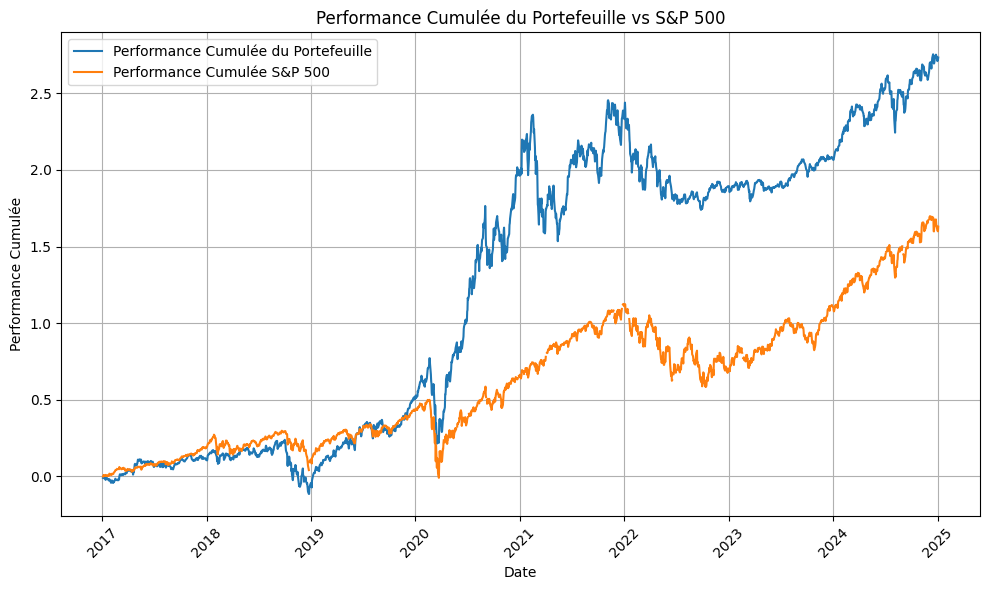

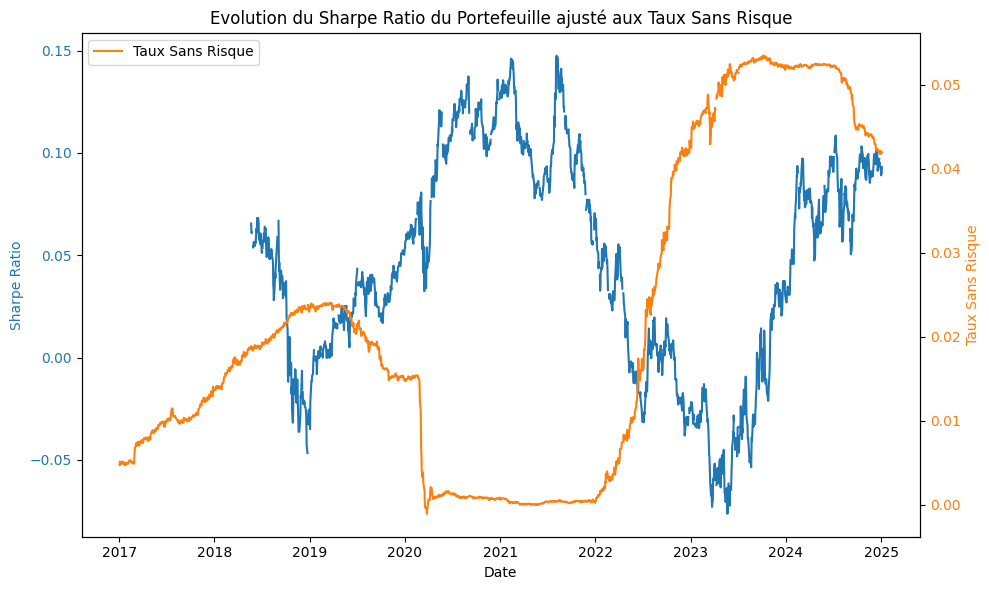

In [48]:



start_time = time.time() #lancement du timer
# Calcul des changements en pourcentage sur CHANGE_TIMEFRAME jours avec lissage
change_df = data.pct_change(periods=MOMENTUM_TIMEFRAME).rolling(window=SMOOTHED_CHANGE_PERIOD).mean()

# Gestion du portefeuille
# Initialisation des paramètres
portfolio_tickers = []  # Liste pour stocker les tickers détenus à chaque date
transactions = {"BUY": [], "SELL": []}  # Enregistrement des transactions (BUY/SELL)

# Fonction principale pour la gestion du portefeuille
for date in change_df.index:
    # Créer une copie de la liste actuelle des tickers détenus
    current_portfolio = portfolio_tickers[-1][1:] if portfolio_tickers else []

    # Calcul des scores ajustés
    scores = {}
    for ticker in change_df.columns:
        if ticker in current_portfolio:
            scores[ticker] = change_df.loc[date, ticker]
        else:
            scores[ticker] = (
                change_df.loc[date, ticker] - TRANSACTION_COST * TRANSACTION_THRESHOLD_FACTOR
            )

    # Trier les tickers par score décroissant
    sorted_tickers = sorted(scores, key=scores.get, reverse=True)
    
    # Sélectionner le top-TOP_HELD
    new_portfolio = sorted_tickers[:TOP_HELD]

    # Identifier les BUY et SELL
    buys = [ticker for ticker in new_portfolio if ticker not in current_portfolio]
    sells = [ticker for ticker in current_portfolio if ticker not in new_portfolio]

    # Enregistrer les transactions
    transactions["BUY"].extend([(date, ticker) for ticker in buys])
    transactions["SELL"].extend([(date, ticker) for ticker in sells])

    # Ajouter la date et le nouveau portefeuille à portfolio_tickers
    portfolio_tickers.append((date, *new_portfolio))


# Conversion des transactions en DataFrame
buy_df = pd.DataFrame(transactions["BUY"], columns=["DATE", "TICKER"])
sell_df = pd.DataFrame(transactions["SELL"], columns=["DATE", "TICKER"])

# Calcul du portefeuille et de la performance cumulée
initial_cash = TOP_HELD*1000.0
cash = initial_cash
portfolio = {}

summary_data = []

for date in change_df.index:
    current_tickers = list(portfolio.keys())
    current_prices = {ticker: data[ticker].loc[date] for ticker in current_tickers}
    
    buys = buy_df[buy_df["DATE"] == date]["TICKER"].tolist()
    sells = sell_df[sell_df["DATE"] == date]["TICKER"].tolist()

    # Effectuer les achats et ventes
    for ticker in buys:
        open_price = data[ticker].loc[date]
        quantity = 1000.0 / open_price
        portfolio[ticker] = quantity
        cash -= 1000.0 * (1 + TRANSACTION_COST)

    for ticker in sells:
        quantity_to_sell = portfolio.pop(ticker, 0)
        sell_price = data[ticker].loc[date]
        cash += quantity_to_sell * sell_price * (1 - TRANSACTION_COST)

    total_value = sum(portfolio[ticker] * data[ticker].loc[date] for ticker in portfolio)
    total_portfolio_value = cash + total_value

    summary_data.append({"DATE": date, "TOTAL_VALUE": total_portfolio_value})

summary_df = pd.DataFrame(summary_data)
summary_df["CUMULATIVE_PERFORMANCE"] = (summary_df["TOTAL_VALUE"] / initial_cash) - 1



# Fusionner directement le DataFrame de ton portefeuille avec le S&P 500
merged_df = pd.merge(summary_df, sp500[['Close']], left_on='DATE', right_index=True, how='left')
merged_df.rename(columns={'Close': 'CLOSE_SP500'}, inplace=True)
# Calcul de la performance cumulée du S&P 500
merged_df['CUMULATIVE_PERFORMANCE_SP500'] = (merged_df['CLOSE_SP500'] / merged_df['CLOSE_SP500'].iloc[0]) - 1
merged_df


# Dernière performance cumulée
last_cumulative_performance = summary_df["CUMULATIVE_PERFORMANCE"].iloc[-1]
print(f"Dernière performance cumulée : {last_cumulative_performance:.4f}")
# Timer: Affichage du temps d'exécution
end_time = time.time()
execution_time = end_time - start_time
print(f"Temps d'exécution complet : {execution_time:.2f} secondes")

# Plot de la performance cumulée du portefeuille et du S&P 500
plt.figure(figsize=(10, 6))

# Tracer la performance cumulée du portefeuille
plt.plot(summary_df["DATE"], summary_df["CUMULATIVE_PERFORMANCE"], label="Performance Cumulée du Portefeuille", color='tab:blue')

# Tracer la performance cumulée du S&P 500
plt.plot(merged_df["DATE"], merged_df["CUMULATIVE_PERFORMANCE_SP500"], label="Performance Cumulée S&P 500", color='tab:orange')

# Ajouter les labels et la légende
plt.title("Performance Cumulée du Portefeuille vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Performance Cumulée")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Ajuster la mise en page
plt.tight_layout()
plt.show()


# Calcul du Sharpe Ratio
merged_df = pd.merge(summary_df, rf_data[['Return']], left_on='DATE', right_index=True, how='left')
merged_df = pd.merge(summary_df, rf_data[['Return']], left_on='DATE', right_index=True, how='left')
merged_df['DAILY_RETURN'] = merged_df['TOTAL_VALUE'].pct_change()

# Calcul de la moyenne et de la volatilité sur une fenêtre glissante
window = 360
merged_df['ROLLING_MEAN'] = merged_df['DAILY_RETURN'].rolling(window=window).mean()
merged_df['ROLLING_STD'] = merged_df['DAILY_RETURN'].rolling(window=window).std()

# Calcul du Sharpe Ratio
merged_df['SHARPE_RATIO'] = (merged_df['ROLLING_MEAN'] - merged_df['Return']/365) / merged_df['ROLLING_STD']

# Plot du Sharpe Ratio et taux sans risque
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(merged_df['DATE'], merged_df['SHARPE_RATIO'], label="Sharpe Ratio (30 jours)", color='tab:blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Sharpe Ratio", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(merged_df['DATE'], merged_df['Return'], label="Taux Sans Risque", color='tab:orange')
ax2.set_ylabel("Taux Sans Risque", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
plt.title("Evolution du Sharpe Ratio du Portefeuille ajusté aux Taux Sans Risque")
fig.tight_layout()
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.show()